# Traffic Sign Recognition with EfficientNet-B0 (Transfer Learning)
**Ders:** Derin Öğrenme (FET312)  
**Takım:** DevTeam177  
**Öğrenci:** [İsminiz Soyisminiz] - [Öğrenci Numaranız]  

**Proje Açıklaması:** Bu notebook dosyasında, trafik levhalarının sınıflandırılması için modern **EfficientNet-B0** mimarisi kullanılmıştır. VGG-16 modeline kıyasla daha parametre verimliliği yüksek olan bu model, ImageNet ağırlıklarıyla başlatılıp trafik levhaları için optimize edilmiştir.

**Hedefler:**
1. Veri setini yüklemek ve EfficientNet formatına (224x224) hazırlamak.
2. Transfer Learning ile EfficientNet-B0 modelini eğitmek.
3. Modelin performansını VGG-16 ile karşılaştırılabilir metriklerle raporlamak.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset, Dataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GroupShuffleSplit
import seaborn as sns
from collections import Counter
import os

# Cihaz konfigürasyonu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan Cihaz: {device}")

# Tekrarlanabilirlik için seed
torch.manual_seed(42)

Kullanılan Cihaz: cuda


## 1. Veri Ön İşleme
EfficientNet-B0 modeli de VGG gibi **224x224** piksel boyutunda girdi bekler. 
Modelin başarısını artırmak için Eğitim setine **Data Augmentation** (Döndürme, Çevirme) uygulanmıştır.

**Not:** EfficientNet, görüntülerdeki karmaşık desenleri yakalamada oldukça başarılıdır, bu yüzden normalizasyon işlemi standart ImageNet değerleriyle yapılır.

In [2]:
data_dir = "C:/Users/aktem/OneDrive/Masaüstü/Derin_Öğrenme/GTSRB/Final_Training/Images"

# Hiperparametreler
BATCH_SIZE = 32
LEARNING_RATE = 0.001

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # <-- KRİTİK: Resmi sayıya çeviren komut
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(), # <-- Burada da olmak zorunda
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
print("Dönüşüm kuralları hazır.")

Dönüşüm kuralları hazır.


## 3. Özelleştirilmiş Dataset Sınıfı (Wrapper)
`Subset` ile ayrılan verilerin üzerine dönüşüm (transform) kurallarını uygulayabilmek için özel bir sınıf yazıyoruz. Bu sınıf, her resim çağrıldığında onu otomatik olarak Tensor'a çevirir.

In [3]:
class CustomDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        # Orijinal subsetten resmi ve etiketi al
        x, y = self.subset[index]
        
        # Eğer bir dönüşüm kuralı varsa (ki var: ToTensor), uygula
        if self.transform:
            x = self.transform(x)
            
        return x, y
        
    def __len__(self):
        return len(self.subset)

print("CustomDataset sınıfı tanımlandı (PIL hatası giderildi).")

CustomDataset sınıfı tanımlandı (PIL hatası giderildi).


## 4. Veri Setini Yükleme ve Sızıntı Korumalı Ayrıştırma
Veri seti, video tabanlı sızıntıyı önlemek için **Track ID**'ye göre gruplandırılır ve ayrıştırılır.

In [4]:
# 1. Ham Veriyi Yükle
full_dataset = datasets.ImageFolder(data_dir) 

# Sınıf İsimlerini Al (Hata almamak için buraya ekledik)
class_names = full_dataset.classes
num_classes = len(class_names)

# 2. Track ID Gruplaması
groups = []
for path, label in full_dataset.imgs:
    file_name = os.path.basename(path)
    track_id = file_name.split('_')[0] 
    groups.append(f"class{label}_{track_id}")

# 3. Sızıntısız Ayırma (%20 Validation)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(X=np.zeros(len(full_dataset)), y=full_dataset.targets, groups=groups))

# Geçici Subsetler (Henüz transforms yok)
train_subset_base = Subset(full_dataset, train_idx)
val_subset_base = Subset(full_dataset, val_idx)

print(f"Ayrıştırma tamamlandı. Train: {len(train_idx)}, Val: {len(val_idx)}")

Ayrıştırma tamamlandı. Train: 31349, Val: 7860


## 5. DataLoader Oluşturma
Ayrıştırılan veriler `CustomDataset` ile sarmalanır (böylece resimler Tensor olur) ve modele beslenmek üzere hazır hale getirilir.

In [5]:
train_dataset = CustomDataset(train_subset_base, transform=data_transforms['train'])
val_dataset = CustomDataset(val_subset_base, transform=data_transforms['val'])

# DataLoader
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
}

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}


try:
    # Veriden bir parça çekmeyi dene
    images, labels = next(iter(dataloaders['train']))
    print(f"BAŞARILI! Veri Tipi: {type(images)}") # <class 'torch.Tensor'> yazmalı
    print(f"Görüntü Boyutu: {images.shape}")
except Exception as e:
    print(f"HATA DEVAM EDİYOR: {e}")

BAŞARILI! Veri Tipi: <class 'torch.Tensor'>
Görüntü Boyutu: torch.Size([32, 3, 224, 224])


## 3. Veri Seti Analizi (Histogram)
Veri setindeki sınıf dağılımı aşağıdadır. (Görüntüleri tek tek okumadan, hızlı sayım yöntemi kullanılmıştır).

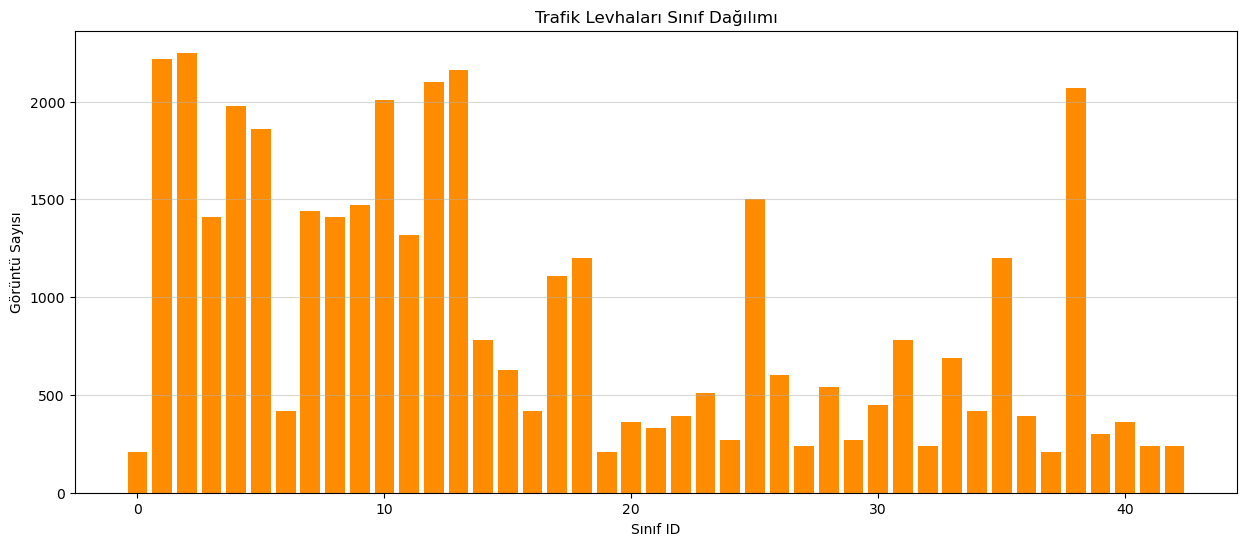

In [6]:
# Hızlı sayım yöntemi (dosyaları açmadan)
labels = full_dataset.targets
label_counts = Counter(labels)

# Grafik
plt.figure(figsize=(15, 6))
plt.bar(label_counts.keys(), label_counts.values(), color='darkorange') # Renk farkı olsun
plt.xlabel('Sınıf ID')
plt.ylabel('Görüntü Sayısı')
plt.title('Trafik Levhaları Sınıf Dağılımı')
plt.grid(axis='y', alpha=0.5)
plt.show()

## 4. EfficientNet-B0 Modelinin Oluşturulması
`torchvision` kütüphanesinden **EfficientNet-B0** modeli indirilmiştir.

* **Yapı:** EfficientNet, VGG'ye göre çok daha derin ama daha az parametre içeren, "Compound Scaling" yöntemini kullanan modern bir mimaridir.
* **Uyarlama:** Modelin özellik çıkaran (features) kısmı dondurulmuş, sınıflandırıcı (classifier) kısmındaki son katman bizim sınıf sayımıza (`num_classes`) göre yeniden tasarlanmıştır.

In [7]:
def get_efficientnet_model(num_classes):
    # EfficientNet-B0 indir
    model = models.efficientnet_b0(pretrained=True)
    
    # Tüm katmanların eğitilmesine izin veriyoruz (Fine-Tuning)
    for param in model.parameters():
        param.requires_grad = True 
    
    # Giriş özellik sayısını al
    in_features = model.classifier[1].in_features
    
    # Yeni sınıflandırıcı bloğu
    model.classifier[1] = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(in_features, num_classes)
    )
    return model

# Modeli tekrar oluştur
model = get_efficientnet_model(num_classes)
model = model.to(device)

# --- DEĞİŞİKLİK 2: LEARNING RATE DÜŞÜRME ---
# Tüm modeli eğittiğimiz için öğrenme hızını (LR) düşürmeliyiz.
# Yoksa model bildiklerini unutur (Catastrophic Forgetting).
# 0.001 yerine 0.0001 yapıyoruz.
LEARNING_RATE = 0.0001 

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("EfficientNet-B0 (Fine-Tuning Modu) Hazır.")

C:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet-B0 (Fine-Tuning Modu) Hazır.


## 5. Modelin Eğitilmesi
Model 10 Epoch boyunca eğitilecektir. EfficientNet genellikle VGG'den daha hızlı yakınsar (converge eder).

In [8]:
NUM_EPOCHS = 10

train_loss_history = []
val_acc_history = []

print("Eğitim Başlıyor (EfficientNet-B0)...")

for epoch in range(NUM_EPOCHS):
    # --- Training ---
    model.train()
    running_loss = 0.0
    
    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_loss_history.append(epoch_loss)
    
    # --- Validation ---
    model.eval()
    running_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            
    epoch_acc = running_corrects.double() / len(val_dataset)
    val_acc_history.append(epoch_acc.item())
    
    print(f'Epoch {epoch+1}/{NUM_EPOCHS} -> Train Loss: {epoch_loss:.4f} | Val Acc: {epoch_acc:.4f}')

Eğitim Başlıyor (EfficientNet-B0)...
Epoch 1/10 -> Train Loss: 0.7540 | Val Acc: 0.9487
Epoch 2/10 -> Train Loss: 0.0579 | Val Acc: 0.9513
Epoch 3/10 -> Train Loss: 0.0244 | Val Acc: 0.9475
Epoch 4/10 -> Train Loss: 0.0166 | Val Acc: 0.9575
Epoch 5/10 -> Train Loss: 0.0121 | Val Acc: 0.9494
Epoch 6/10 -> Train Loss: 0.0113 | Val Acc: 0.9569
Epoch 7/10 -> Train Loss: 0.0087 | Val Acc: 0.9545
Epoch 8/10 -> Train Loss: 0.0057 | Val Acc: 0.9570
Epoch 9/10 -> Train Loss: 0.0069 | Val Acc: 0.9573
Epoch 10/10 -> Train Loss: 0.0057 | Val Acc: 0.9545


## 6. Sonuçların Görselleştirilmesi
Eğitim kaybı ve doğrulama başarısı grafikleri. Bu grafikleri VGG-16 grafikleriyle karşılaştırabilirsiniz.

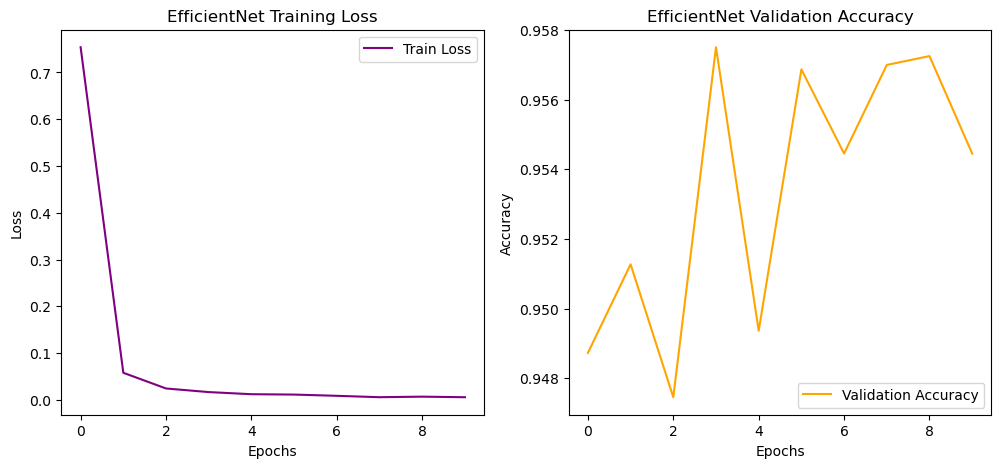

In [9]:
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss', color='purple') # Farklı renk
plt.title('EfficientNet Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(val_acc_history, label='Validation Accuracy', color='orange')
plt.title('EfficientNet Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 7. Performans Değerlendirmesi
Modelin sınıf bazlı başarımı (Precision, Recall, F1-Score) ve karışıklık matrisi.

In [10]:
# --- HÜCRE 18: DÜZELTİLMİŞ RAPORLAMA KODU ---

import pandas as pd
from sklearn.metrics import classification_report

def get_classification_report_dataframe(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    
    # Verileri topla
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    # --- HATAYI ÇÖZEN KISIM BURASI ---
    # labels=range(num_classes) diyerek 43 sınıfın hepsini zorluyoruz.
    # Validation setinde olmayan sınıflar için 0.0 basacak ama hata vermeyecek.
    report_dict = classification_report(
        y_true, 
        y_pred, 
        target_names=class_names, 
        labels=range(num_classes), # <--- EKLENEN KRİTİK SATIR
        output_dict=True, 
        zero_division=0
    )
    
    # Pandas DataFrame'e çevir
    df_report = pd.DataFrame(report_dict).transpose()
    
    # 'support' sütununu tam sayı yap
    df_report['support'] = df_report['support'].astype(int)
    
    return df_report

# Raporu Oluştur
print("Final Test Raporu Hazırlanıyor...")
# model yerine trained_model veya en son eğittiğin model değişkenini kullan
df_results = get_classification_report_dataframe(model, dataloaders['val'])

print(f"Model: {model.__class__.__name__} - Sınıf Bazlı Performans")
display(df_results)

# CSV Olarak Kaydet
df_results.to_csv('DevTeam177_Final_Report_Results.csv')
print("Tablo kaydedildi.")

Final Test Raporu Hazırlanıyor...
Model: EfficientNet - Sınıf Bazlı Performans


,precision,recall,f1-score,support
00000,0.000000,0.000000,0.000000,0
00001,1.000000,0.980556,0.990182,360
00002,0.983412,0.988095,0.985748,420
00003,0.987654,1.000000,0.993789,240
00004,1.000000,0.993750,0.996865,480
00005,0.973856,0.993333,0.983498,300
00006,1.000000,1.000000,1.000000,120
00007,0.996310,1.000000,0.998152,270
00008,0.985915,1.000000,0.992908,210
00009,1.000000,0.990000,0.994975,300


Tablo kaydedildi.


## 8. Karmaşıklık Matrisi (Confusion Matrix)
EfficientNet-B0 modelinin sınıflandırma performansını daha derinlemesine incelemek için **Karmaşıklık Matrisi** oluşturulur.
* **Amacı:** Modelin hangi sınıfları doğru bildiğini ve hangi sınıfları birbiriyle karıştırdığını (örn: 30 km/s ile 50 km/s hız sınırları) görselleştirmek.
* **Yorumlama:** Matrisin köşegeni (diyagonal) üzerindeki koyu renkli kutucuklar doğru tahminleri, köşegen dışındaki renklenmeler ise hataları temsil eder.

Tahminler alınıyor...


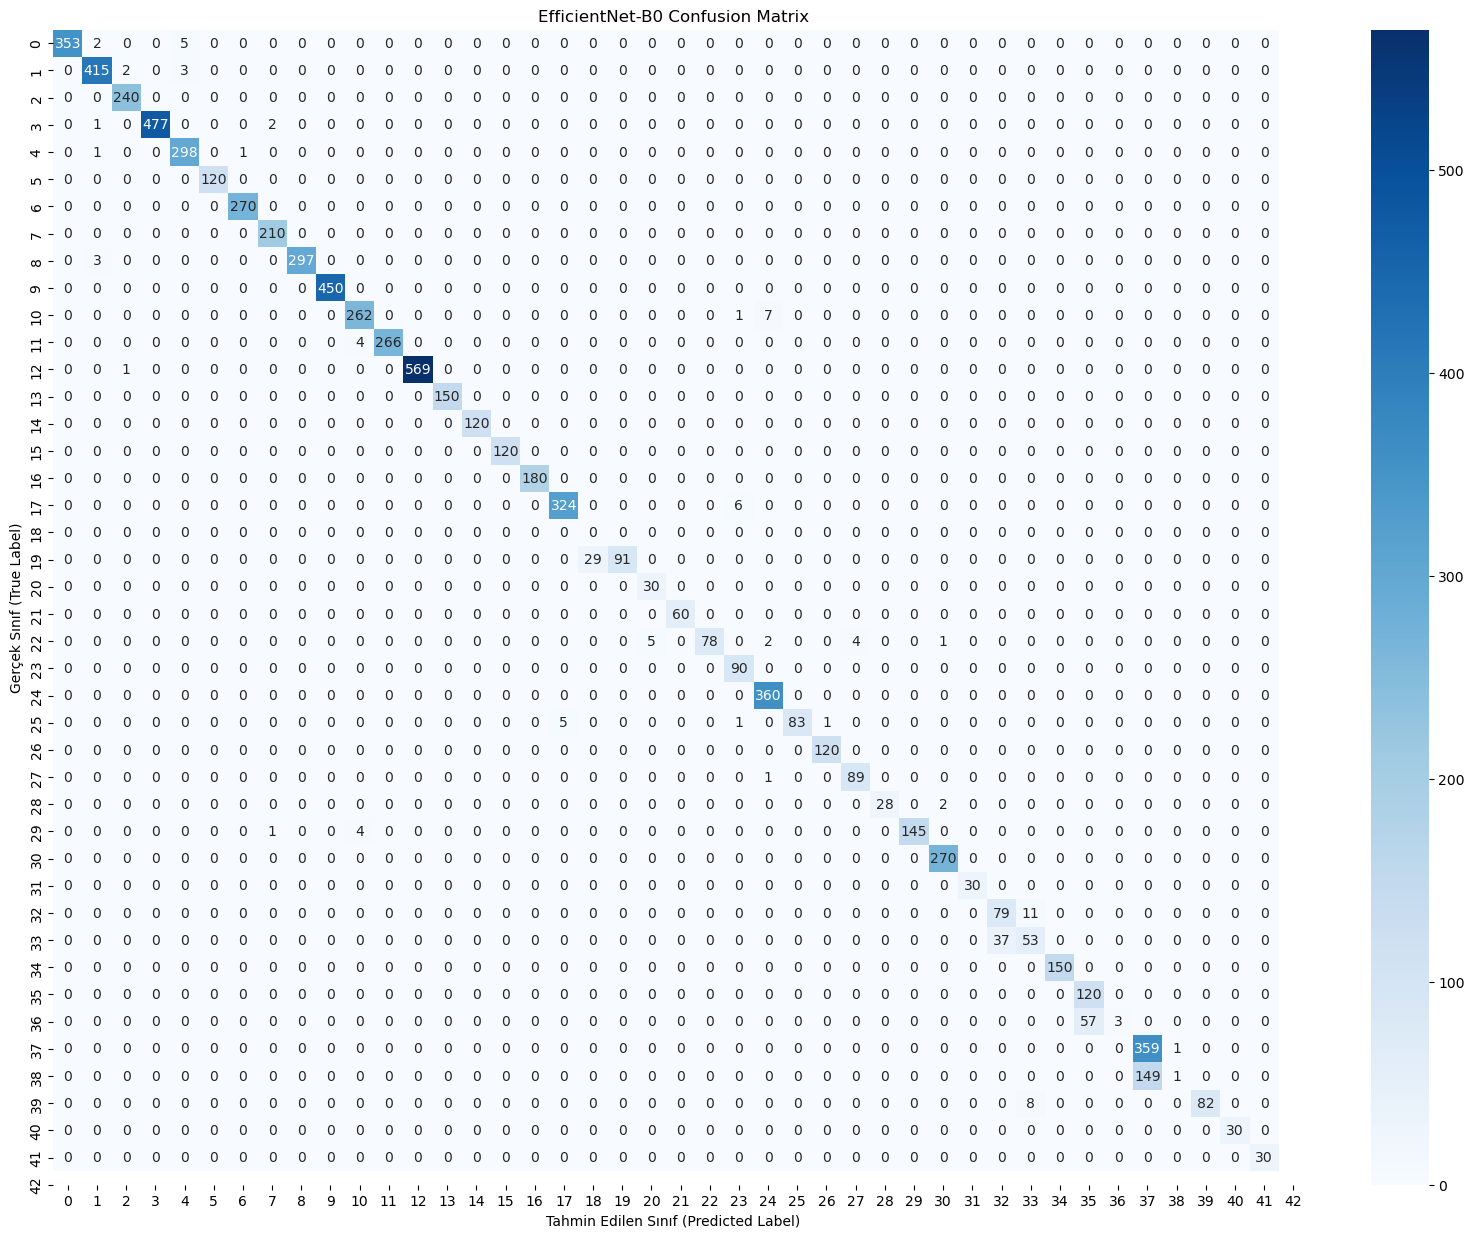

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    
    print("Tahminler alınıyor...")
    # Verileri topla
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    # Matrisi hesapla
    cm = confusion_matrix(y_true, y_pred)
    
    # Grafiği çiz
    plt.figure(figsize=(20, 15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', # EfficientNet için Turuncu tonları
                xticklabels=range(num_classes), 
                yticklabels=range(num_classes))
    
    plt.title('EfficientNet-B0 Confusion Matrix')
    plt.ylabel('Gerçek Sınıf (True Label)')
    plt.xlabel('Tahmin Edilen Sınıf (Predicted Label)')
    plt.show()

# Fonksiyonu çalıştır
plot_confusion_matrix(model, dataloaders['val'])